In [1]:
from keras import optimizers
import tensorflow as tf
import efficientnet.tfkeras as efn
from keras.models import Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard

2023-05-01 18:24:59.736881: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# 0 : VGG16
# 1 : ResNet50
# 2 : EfficientNet_B2
CNN_name = ['VGG16', 'ResNet50', 'EfficientNet_B2']

In [3]:
CNN_Serial_number = 0

In [4]:
# NB_CLASSL: number of classes
NB_CLASS = 5

In [5]:
# Whether to perform data augmentation. 0 does not extend data. 1 Extended data
augmentation_name = ['No_Aug', 'Aug']
augmentation = 0

In [6]:
# According to the machine memory
batch_size = 32

In [7]:
# Total training rounds
EPOCH = 25

In [8]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

In [9]:
train_root = './dataset-Simpsons_Main_Characters/train_images/'
validation_root = './dataset-Simpsons_Main_Characters/test_images/'

In [10]:
# log display level
verbose = 1

In [11]:
# loss function
loss = tf.keras.losses.categorical_crossentropy

In [12]:
# optimize function
# RMSprop
# optimizer = optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=None, decay=0.0)

# Adam
# optimizer = optimizers.adam.Adam(learning_rate=0.001, beta_1=0.9, beta_2 = 0.999, epsilon=None, amsgrad = False)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

In [13]:
# Data processing
My_ImageDatagenerator = ImageDataGenerator(
    width_shift_range=0.1, 
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    rescale=1. / 255,
)

In [14]:
train_generator = My_ImageDatagenerator.flow_from_directory(
    train_root,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=batch_size,
    shuffle=True
)
valid_generator = My_ImageDatagenerator.flow_from_directory(
    validation_root,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=batch_size,
)

Found 6936 images belonging to 5 classes.
Found 404 images belonging to 5 classes.


In [15]:
import keras.applications as cnn_model
if CNN_Serial_number == 0:
    base_model = cnn_model.vgg16.VGG16(weights='./pretrained/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False)
elif CNN_Serial_number == 1:
    base_model = cnn_model.resnet.ResNet50(weights='./pretrained/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False)
elif CNN_Serial_number == 2:
    base_model = efn.EfficientNetB2(weights='./pretrained/efficientnet-b2_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5', include_top=False)
    
    
    

In [16]:
#Add global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)


In [17]:
# add a fully connected layer
x = Dense(256, activation='relu')(x)

In [18]:
# add a classifier
predictions = Dense(NB_CLASS, activation='softmax')(x)

In [19]:
#Build the complete model we need to train

model = Model(inputs=base_model.input, outputs=predictions)

In [20]:
# Migration learning, only train the last 10 layers
for layer in model.layers:
    layer.trainable = False
for i in range(-10, 0):
    model.layers[i].trainable = True

In [21]:
from keras import metrics

In [22]:
# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=['acc', metrics.Precision(), metrics.Recall()])

In [23]:
# print model structure
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [24]:
import time
# log storage path
now = int(time.time())
timeArray = time.localtime(now)
otherStyleTime = time.strftime("%Y-%m-%d-%H-%M-%S", timeArray)
log_dir = './logs/' + CNN_name[CNN_Serial_number] + '_'+augmentation_name[augmentation]+'_'+otherStyleTime


In [25]:
tbCallBack = TensorBoard(log_dir=log_dir, histogram_freq=1, update_freq="epoch", )

In [26]:
#Save path of optimal model
filePath = './' + CNN_name[CNN_Serial_number] + '_'+augmentation_name[augmentation]+'_best.h5'


In [27]:
#If there is an upgrade, it will be overwritten once
checkpoint = ModelCheckpoint(filePath, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_freq='epoch')



In [28]:
callbacks_list = [checkpoint, tbCallBack]


In [29]:
# train on the dataset
# after 10 epoch val_acc did not improved， so terminated
# use "tensorboard --logdir=./logs" show plt
history = model.fit(train_generator, 
                    validation_data=valid_generator,
                    epochs=EPOCH,
                    steps_per_epoch=train_generator.n / batch_size,
                    validation_steps=valid_generator.n / batch_size,
                    verbose = verbose,
                    callbacks = callbacks_list)

Epoch 1/25


2023-05-01 18:25:05.894534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


217/216 [==============================] - ETA: -1s - loss: 0.8352 - acc: 0.6948 - precision: 0.9249 - recall: 0.4863

2023-05-01 18:45:19.833859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_acc improved from -inf to 0.77475, saving model to ./VGG16_No_Aug_best.h5
216/216 [==============================] - 1267s 6s/step - loss: 0.8352 - acc: 0.6948 - precision: 0.9249 - recall: 0.4863 - val_loss: 0.6353 - val_acc: 0.7748 - val_precision: 0.8338 - val_recall: 0.7327
Epoch 2/25
217/216 [==============================] - ETA: -1s - loss: 0.2026 - acc: 0.9369 - precision: 0.9597 - recall: 0.9142
Epoch 2: val_acc improved from 0.77475 to 0.81436, saving model to ./VGG16_No_Aug_best.h5
216/216 [==============================] - 1328s 6s/step - loss: 0.2026 - acc: 0.9369 - precision: 0.9597 - recall: 0.9142 - val_loss: 0.5412 - val_acc: 0.8144 - val_precision: 0.8722 - val_recall: 0.7772
Epoch 3/25
217/216 [==============================] - ETA: -1s - loss: 0.1260 - acc: 0.9642 - precision: 0.9755 - recall: 0.9540
Epoch 3: val_acc improved from 0.81436 to 0.86881, saving model to ./VGG16_No_Aug_best.h5
216/216 [==============================] - 1242s 6s/step - loss:

KeyboardInterrupt: 

In [30]:
trained_filePath = './p_trained/' + CNN_name[CNN_Serial_number] + '_'+augmentation_name[augmentation]+'_'+otherStyleTime+'_best.h5'


In [31]:
from joblib import Parallel, delayed
import joblib


# Save the model as a pickle in a file
joblib.dump(model, trained_filePath)

['./p_trained/VGG16_No_Aug_2023-05-01-18-25-05_best.h5']

In [53]:
# Visualization of Accuracy and loss
# Loss
# after 10 epoch val_acc did not improved， so terminated
# use "tensorboard --logdir=./logs" show plt
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCH)

plt.figure(figsize=(12, 10))
plt.plot(epochs_range, train_loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc='upper left')
plt.title('Train and Validation Loss ' + CNN_name[CNN_Serial_number])

plt.show()

In [54]:
# Accuracy
# after 10 epoch val_acc did not improved， so terminated
# use "tensorboard --logdir=./logs" show plt
train_acc = history.history['acc']
val_acc = history.history['val_acc']

epochs_range = range(EPOCH)

plt.figure(figsize=(5, 5))
plt.plot(epochs_range, train_acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc='upper left')
plt.title('Train and Validation Acc ' + CNN_name[CNN_Serial_number])

plt.show()

In [37]:
# Image test

test_root = './test/'
# Load the model from the file
from_model = joblib.load(trained_filePath)
print(trained_filePath)
test_datagen = ImageDataGenerator(
    rescale=1. / 255
)
test_genertor = test_datagen.flow_from_directory(
    test_root,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=batch_size,
)

result = from_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc', metrics.Precision(), metrics.Recall()])



./p_trained/VGG16_No_Aug_2023-05-01-18-25-05_best.h5
Found 5 images belonging to 5 classes.


In [38]:
model.evaluate(test_genertor, 
               max_queue_size=10, workers=1, use_multiprocessing=False, verbose=verbose)



2023-05-01 21:32:43.523993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 460ms/step - loss: 0.8636 - acc: 0.8000 - precision: 0.8000 - recall: 0.8000


[0.8636301755905151, 0.800000011920929, 0.800000011920929, 0.800000011920929]

In [39]:
print(type(test_genertor.n / batch_size))
print(test_genertor.n / batch_size)

<class 'float'>
0.15625


In [40]:
# confusion matrix
display_labels = range(0, NB_CLASS)

In [41]:
show_figure = False
normalization = True

In [42]:
def test(picname, model):
    keras.backend.clear_session()
    img_path = picname
    test_image = image.load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    test_image_test_image/255
    predict = model.predict(tesy_image)
    preds = np.argmax(predict, axis=1)[0]
    return preds

In [44]:
test_gen = test_datagen.flow_from_directory(test_root, target_size=(IMG_WIDTH, IMG_HEIGHT))
print(test_gen.class_indices)

Found 5 images belonging to 5 classes.
{'bart_simpson': 0, 'homer_simpson': 1, 'lisa_simpson': 2, 'maggie_simpson': 3, 'marge_simpson': 4}


min: 0.0 max: 0.96470594


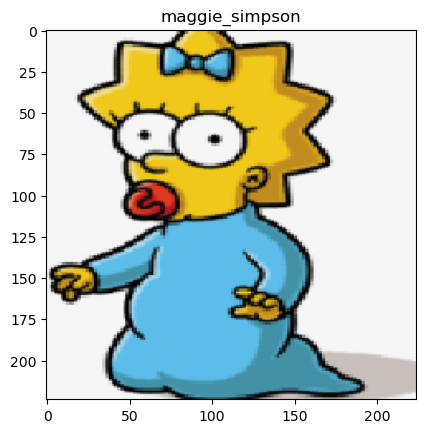

['bart_simpson', 'homer_simpson', 'lisa_simpson', 'maggie_simpson', 'marge_simpson']


In [47]:
import matplotlib.pyplot as plt
import numpy as np
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
    labels[v] = k

# should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_gen:
    print("min:", x[0].min(), "max:", x[0].max())
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    plt.show()
    break
print(labels)

In [48]:
import itertools


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.rcParams["figure.figsize"] = (40,20)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")
  
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [49]:
from glob import glob

# useful for getting number of files
image_files = glob(train_root + '/*/*.jp*g')
test_image_files = glob(test_root + '/*/*.jp*g')

# useful for getting number of classes
folders = glob(train_root + '/*')
print(folders)

['./dataset-Simpsons_Main_Characters/train_images/maggie_simpson', './dataset-Simpsons_Main_Characters/train_images/marge_simpson', './dataset-Simpsons_Main_Characters/train_images/bart_simpson', './dataset-Simpsons_Main_Characters/train_images/lisa_simpson', './dataset-Simpsons_Main_Characters/train_images/homer_simpson']


In [50]:
import os
import json
import glob
from prettytable import PrettyTable





class ConfusionMatrix(object):
    def __init__(self, num_classes: int, labels: list):
        self.matrix = np.zeros((num_classes, num_classes))
        self.num_classes = num_classes
        self.labels = labels

    def update(self, preds, labels):
        for p, t in zip(preds, labels):
            self.matrix[p, t] += 1

    def summary(self):
        # calculate accuracy
        sum_TP = 0
        for i in range(self.num_classes):
            sum_TP += self.matrix[i, i]
        acc = sum_TP / np.sum(self.matrix)
        print("the model accuracy is ", acc)

        # precision, recall, specificity
        table = PrettyTable()
        table.field_names = ["", "Precision", "Recall", "Specificity", 'F1']
        for i in range(self.num_classes):
            TP = self.matrix[i, i]
            FP = np.sum(self.matrix[i, :]) - TP
            FN = np.sum(self.matrix[:, i]) - TP
            TN = np.sum(self.matrix) - TP - FP - FN
            Precision = round(TP / (TP + FP), 3) if TP + FP != 0 else 0.
            Recall = round(TP / (TP + FN), 3) if TP + FN != 0 else 0.
            Specificity = round(TN / (TN + FP), 3) if TN + FP != 0 else 0.
            F1 = 2*Precision*Recall/(Precision+Recall) if Precision+Recall != 0 else 0.
            table.add_row([self.labels[i], Precision, Recall, Specificity, F1])
        print(table)

    def plot(self):
        matrix = self.matrix
        print(matrix)
        plt.imshow(matrix, cmap=plt.cm.Blues)

        plt.xticks(range(self.num_classes), self.labels, rotation=45)
        plt.yticks(range(self.num_classes), self.labels)
        plt.colorbar()
        plt.xlabel('True Labels')
        plt.ylabel('Predicted Labels')
        plt.title('Confusion matrix')

        thresh = matrix.max() / 2
        for x in range(self.num_classes):
            for y in range(self.num_classes):
                info = int(matrix[y, x])
                plt.text(x, y, info,
                         verticalalignment='center',
                         horizontalalignment='center',
                         color="white" if info > thresh else "black")
        plt.tight_layout()
        plt.show()


Found 404 images belonging to 5 classes.


  0%|                                                    | 0/13 [00:00<?, ?it/s]2023-05-01 21:35:31.902027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [32,224,224,3]
	 [[{{node Placeholder/_0}}]]
  8%|███▍                                        | 1/13 [00:02<00:31,  2.62s/it]2023-05-01 21:35:34.507263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [32,224,224,3]
	 [[{{node Placeholder/_0}}]]
 15%|██████▊                                     | 2/13 [00:05<00:27,  2.53s/it]2023-05-01 21:35:36.974620: I tensorflow/core/common_runti

[[79.  0.  0.  0.  2.]
 [ 0. 81.  0.  1.  1.]
 [ 2.  0. 78. 22.  3.]
 [ 0.  0.  2. 58.  0.]
 [ 0.  0.  0.  0. 75.]]


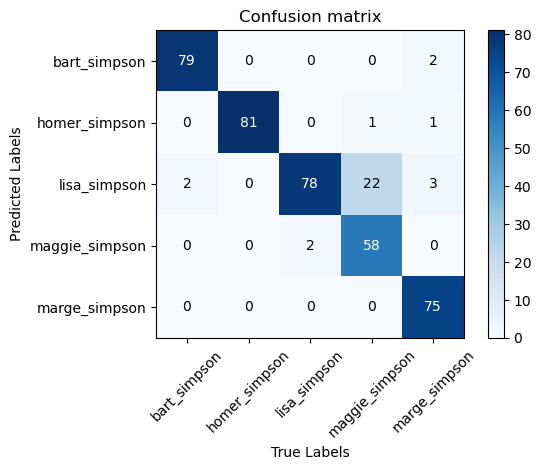

the model accuracy is  0.9183168316831684
+----------------+-----------+--------+-------------+--------------------+
|                | Precision | Recall | Specificity |         F1         |
+----------------+-----------+--------+-------------+--------------------+
|  bart_simpson  |   0.975   | 0.975  |    0.994    |       0.975        |
| homer_simpson  |   0.976   |  1.0   |    0.994    | 0.9878542510121457 |
|  lisa_simpson  |   0.743   | 0.975  |    0.917    | 0.8433352735739231 |
| maggie_simpson |   0.967   | 0.716  |    0.994    | 0.8227831253713608 |
| marge_simpson  |    1.0    | 0.926  |     1.0     | 0.9615784008307372 |
+----------------+-----------+--------+-------------+--------------------+


In [52]:

from tqdm import tqdm
import math
def pre_function(img):
    # img = im.open('test.jpg')
    # img = np.array(img).astype(np.float32)
    img = img / 255.
    img = (img - 0.5) * 2.0
    return img


# data generator with data augmentation
validation_image_generator = ImageDataGenerator(preprocessing_function=pre_function)

val_data_gen = validation_image_generator.flow_from_directory(directory=validation_root,
                                                              batch_size=batch_size,
                                                              shuffle=False,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical')
# img, _ = next(train_data_gen)
total_val = val_data_gen.n
confusion = ConfusionMatrix(num_classes=NB_CLASS, labels=labels)

# validate
for step in tqdm(range(math.ceil(total_val / batch_size))):
    val_images, val_labels = next(val_data_gen)
    results = from_model.predict_on_batch(val_images)
    results = tf.keras.layers.Softmax()(results).numpy()
    results = np.argmax(results, axis=-1)
    labels1 = np.argmax(val_labels, axis=-1)
    confusion.update(results, labels1)
confusion.plot()
confusion.summary()

In [55]:
print(NB_CLASS)
print(labels)
print(len(labels))

5
['bart_simpson', 'homer_simpson', 'lisa_simpson', 'maggie_simpson', 'marge_simpson']
5


In [59]:
# Validation data set with visualisation to check the prediction
def predict(model, img):
    img_array = tf.keras.utils.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 0)
    return predicted_class, confidence

In [63]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_root,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(IMG_HEIGHT, IMG_HEIGHT),
    batch_size=batch_size
)

Found 6936 files belonging to 5 classes.
Using 1387 files for validation.


In [64]:
# Visualisation according to the classes
class_names = val_ds.class_names
print(class_names)
num_classes = len(class_names)

for images, labels in val_ds.take(1):
    print(labels)
    print(labels[10])
    print(class_names[labels[10]])

['bart_simpson', 'homer_simpson', 'lisa_simpson', 'maggie_simpson', 'marge_simpson']
tf.Tensor([4 0 3 3 1 4 1 4 1 0 4 1 0 4 1 0 4 1 2 1 3 2 2 0 1 3 2 1 1 0 3 3], shape=(32,), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
marge_simpson


2023-05-03 00:46:34.540977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1387]
	 [[{{node Placeholder/_4}}]]
2023-05-03 00:46:34.541316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1387]
	 [[{{node Placeholder/_4}}]]


2023-05-03 00:46:41.818835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1387]
	 [[{{node Placeholder/_0}}]]
2023-05-03 00:46:41.819166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1387]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 103ms/step


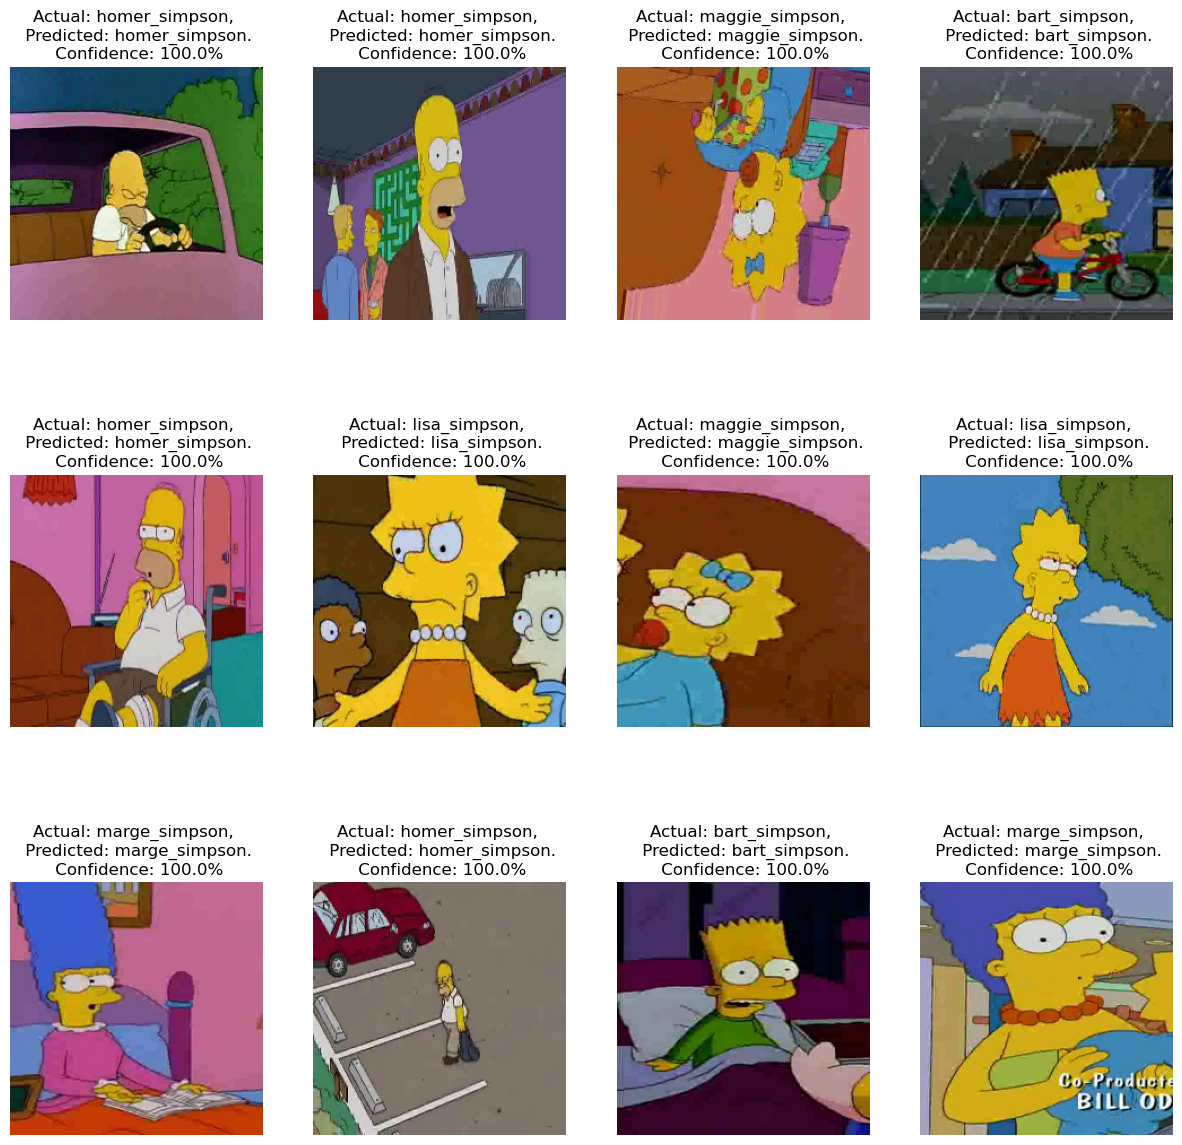

In [65]:
plt.figure(figsize=(15, 15))
for images, labels in val_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis('off')